In [9]:
import sys
import nest
import numpy as np
import matplotlib.pyplot as plt

All system models inherit from the `Network` base class.

In [10]:
from fna.tools.network_architect import Network
[func for func in dir(Network) if callable(getattr(Network, func)) and not func.startswith("__")]

['initialize_states', 'predict', 'report', 'train']

---

In [11]:
from fna.networks.snn import SpikingNetwork
from fna.tools.utils import set_recording_device
from fna.tools.utils.system import set_kernel_defaults, reset_nest_kernel
from fna.tools.network_architect.topology import set_positions
from fna.tools.visualization.plotting import plot_spectral_radius, plot_histograms, plot_spatial_connectivity, plot_network_topology

# **10. `SpikingNetwork` (SNN)** <a id='section8'></a>

The SNN simulator is a wrapper for PyNEST. So, any neuron and synapse model realizable in NEST can be used within this framework.

In [12]:
# Specify system and simulation parameters
resolution = 0.1
data_label = 'test_network'
system = 'local'
system_params = {
    'nodes': 1,
    'ppn': 16,
    'mem': 8,
    'walltime': '01-00:00:00',
    'queue': 'batch'}
paths = {
    'local': {  # storage label
        'data_path': '../data/',  # path for data (in/out)
        'jdf_template': 	None, # TODO remove
        'matplotlib_rc': 	None, # 
        'remote_directory': None,
        'queueing_system':  None}}

# initialize NEST kernel
kernel_pars = set_kernel_defaults(run_type=system, data_label=data_label, data_paths=paths, **system_params)
reset_nest_kernel(kernel_pars)

In [13]:
# #####################################################################################
# ## A) Simple Brunel BRN
# #####################################################################################
# Specify network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 5000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 1000                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

neuron_params = {
            'model': 'iaf_psc_delta',
            'C_m': 1.0,      # membrane capacity (pF)
            'E_L': 0.,       # resting membrane potential (mV)
            'I_e': 0.,       # external input current (pA)
            'V_m': 0.,       # membrane potential (mV)
            'V_reset': 10.,  # reset membrane potential after a spike (mV)
            'V_th': 20.,     # spike threshold (mV)
            't_ref': 2.0,    # refractory period (ms)
            'tau_m': 20.,    # membrane time constant (ms)
        }

## 10.1. Creating SNNs - `SpikingNetwork`

### 10.1.1. Simple BRN

In [14]:
snn_parameters = {
    'populations': ['E', 'I'],
    'population_size': [NE, NI],
    'neurons': [neuron_params, neuron_params],
    'randomize': [
        {'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})},
        {'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})}]}

spike_recorder = set_recording_device(start=0., stop=sys.float_info.max, resolution=resolution, record_to='memory',
                                      device_type='spike_detector')
spike_recorders = [spike_recorder for _ in snn_parameters['populations']]

# Generate SNN instance
snn = SpikingNetwork(snn_parameters, label='Brunel BRN', topologies=None, spike_recorders=spike_recorders,
                     analog_recorders=None)

[__init__.py:49 - INFO] Initializing Brunel BRN architecture (NEST-simulated)
[__init__.py:123 - INFO] Creating populations:
[__init__.py:115 - INFO] - Population E, with ids [1-5000]
[__init__.py:115 - INFO] - Population I, with ids [5001-6250]
[__init__.py:440 - INFO] Connecting Devices: 
[__init__.py:128 - INFO]   - Attaching spike_detector with gid [(6251,)] to population E
[__init__.py:461 - INFO] - Connecting spike_detector to E, with label E_spike_detector and id (6251,)
[__init__.py:128 - INFO]   - Attaching spike_detector with gid [(6252,)] to population I
[__init__.py:461 - INFO] - Connecting spike_detector to I, with label I_spike_detector and id (6252,)
[__init__.py:145 - INFO] Initializing state variables:
[__init__.py:94 - INFO] - Randomizing V_m state in Population E
[__init__.py:94 - INFO] - Randomizing V_m state in Population I
[__init__.py:1086 - INFO] ========================================================
[__init__.py:1087 - INFO]  Brunel BRN architecture (NEST-sim

### 10.1.2. SNN with complex, nested populations

In [15]:
# #####################################################################################
# ## B) SNN with nested populations
# #####################################################################################
# nested_snn_parameters = {
#     'populations': [['E1', 'I1'], ['E2', 'I2']],
#     'population_size': [[NE, NI], [NE, NI]],
#     'neurons': [[neuron_params, neuron_params], [neuron_params, neuron_params]],
#     'randomize': [
#         [{'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})},
#          {'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})}],
#         [{'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})},
#          {'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})}]]}
# nested_snn = SpikingNetwork(nested_snn_parameters, label='Nested BRN')

[__init__.py:49 - INFO] Initializing Nested BRN architecture (NEST-simulated)
[__init__.py:123 - INFO] Creating populations:


TypeError: Population name (['E1', 'I1']) must be of type string!

### 10.1.3. SNN with topology

In [16]:
# #####################################################################################
# ## C) SNN with topology
# #####################################################################################
from tools.network_architect.topology import set_positions
from tools.utils.operations import copy_dict

N = NE + NI

# for simplicity all other parameters are the same, only topology is added
layer_properties = {
    'center': [np.round(np.sqrt(N)) / 2., np.round(np.sqrt(N)) / 2.],
    'extent': [np.ceil(np.sqrt(N)), np.ceil(np.sqrt(N))],
    'edge_wrap': True, 'elements': neuron_params['model']}
pos = set_positions(N=N, dim=2, topology='random')
E_layer_properties = copy_dict(layer_properties, {'positions': pos[:int(NE)]})
I_layer_properties = copy_dict(layer_properties, {'positions': pos[int(NE):]})

topology_snn_parameters = {
    'populations': ['tpE', 'tpI'],
    'population_size': [NE, NI],
    'neurons': [neuron_params, neuron_params],
    'randomize': [
        {'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})},
        {'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})}]}

topology_snn = SpikingNetwork(topology_snn_parameters, label='BRN with spatial topology', topologies=[
    E_layer_properties, I_layer_properties])

[__init__.py:49 - INFO] Initializing BRN with spatial topology architecture (NEST-simulated)
[__init__.py:123 - INFO] Creating populations:
/home/neuro/Desktop/software/nest-engine/in_use/nest-2.20.0-py3.6/nest-install/lib/python3.6/site-packages/nest/lib/hl_api_helper.py:127: UserWarning:
GetLeaves is deprecated and will be removed in NEST 3.0. Use             GIDCollection instead.
[__init__.py:115 - INFO] - Population tpE, with ids [6254-11253]
[__init__.py:115 - INFO] - Population tpI, with ids [11255-12504]
[__init__.py:440 - INFO] Connecting Devices: 
[__init__.py:145 - INFO] Initializing state variables:
[__init__.py:94 - INFO] - Randomizing V_m state in Population tpE
[__init__.py:94 - INFO] - Randomizing V_m state in Population tpI
[__init__.py:1086 - INFO] ========================================================
[__init__.py:1087 - INFO]  BRN with spatial topology architecture (NEST-simulated):
[__init__.py:1088 - INFO] --------------------------------------------------------

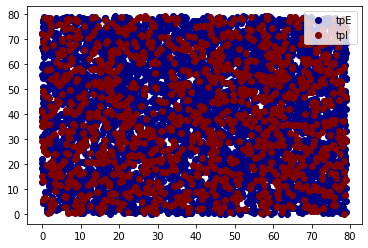

In [17]:
fig, ax = plt.subplots()
plot_network_topology(topology_snn, ax=ax, display=False)

## 10.2. Connecting SNNs - `NESTConnector`

In [18]:
from fna.tools.network_architect.connectivity import NESTConnector

In [19]:
# ###################################################################################
# Connectivity
# E synapses
syn_exc = {'model': 'static_synapse', 'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
# I synapses
syn_inh = {'model': 'static_synapse', 'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}

snn_synapses = {
    'connect_populations': [('E', 'E'), ('E', 'I'), ('I', 'E'), ('I', 'I')],
    'weight_matrix': [None, None, None, None],
    'conn_specs': [conn_exc, conn_inh, conn_exc, conn_inh],
    'syn_specs': [syn_exc, syn_inh, syn_exc, syn_inh]
}
snn_recurrent_connections = NESTConnector(source_network=snn, target_network=snn, connection_parameters=snn_synapses)
# w_rec = snn_recurrent_connections.compile_weights()

[connectivity.py:262 - INFO] Connecting networks: Brunel BRN -> Brunel BRN
[connectivity.py:271 - INFO]     - ('E', 'E') [static_synapse]
[connectivity.py:271 - INFO]     - ('E', 'I') [static_synapse]
[connectivity.py:271 - INFO]     - ('I', 'E') [static_synapse]
[connectivity.py:271 - INFO]     - ('I', 'I') [static_synapse]


### 10.2.1. Topological connections

[connectivity.py:262 - INFO] Connecting networks: BRN with spatial topology -> BRN with spatial topology
[connectivity.py:271 - INFO]     - ('tpE', 'tpE') [static_synapse]
[connectivity.py:271 - INFO]     - ('tpE', 'tpI') [static_synapse]
[connectivity.py:271 - INFO]     - ('tpI', 'tpE') [static_synapse]
[connectivity.py:271 - INFO]     - ('tpI', 'tpI') [static_synapse]


AttributeError: 'str' object has no attribute 'layer_gid'

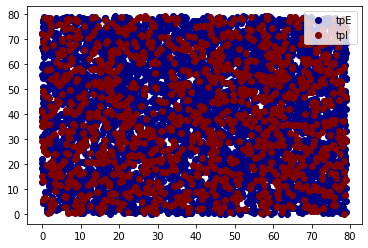

In [20]:
# E synapses
syn_exc = {'model': 'static_synapse', 'delay': d, 'weight': w}
# I synapses
syn_inh = {'model': 'static_synapse', 'delay': d, 'weight': - g * w}

conn_dict = {'connection_type': 'divergent',
             'mask': {'circular': {'radius': 20.}},
             'kernel': {'gaussian': {'p_center': 1.0, 'sigma': 0.25}},
             'synapse_model': 'static_synapse',
             'weights': {'gaussian': {'p_center': w, 'sigma': 0.25 * w}}}
topology_snn_synapses = {
    'connect_populations': [('tpE', 'tpE'), ('tpE', 'tpI'), ('tpI', 'tpE'), ('tpI', 'tpI')],
    'weight_matrix': [None, None, None, None],
    'conn_specs': [{}, {}, {}, {}],
   'syn_specs': [syn_exc, syn_inh, syn_exc, syn_inh]
}
topology_connections = NESTConnector(source_network=topology_snn, target_network=topology_snn,
                                        connection_parameters=topology_snn_synapses, topology=[conn_dict, conn_dict,
                                                                                               conn_dict, conn_dict])
w_rec = topology_connections.compile_weights()
fig, ax = plt.subplots()
plot_network_topology(topology_snn, ax=ax, display=False)
#plot_spatial_connectivity(topology_snn, kernel=conn_dict['kernel'], mask=conn_dict['mask'], ax=ax)

## 10.3. Profiling SNNs

#### 10.3.1. Single neuron properties

In [11]:
snn.neuron_transferfunction?

Signature:
snn.neuron_transferfunction(
    gid=None,
    input_type='rate',
    input_range=None,
    input_weights=None,
    total_time=1000.0,
    step=100.0,
    restore=False,
    plot=True,
    display=True,
    save=False,
)
Docstring:
Numerically determine a single neuron's rate or current transfer function for the selected neurons or for a
representative set
:param gid: int, list or tuple - id of the neuron to record from (if None, one random neuron will be used)
:param input_type: str - 'rate' or 'current' input
:param input_range: list or tuple - range of input firing rates (Hz) or currents (pA)
:param input_weights: list or tuple - synaptic weights for E/I spike input (valid only if input_type='rate')
:param total_time: [ms] float
:param step: [ms] duration of a single I/O measurement
:param restore: bool - save and restore network state after analysis
:param plot: bool - plot the main results
:param display: bool - show plots and detailed outputs
:param save: store results

In [12]:
# 1) Single neuron fI curves
results = snn.neuron_transferfunction(gid=100, input_type='current', input_range=(0., 10.), total_time=100000.,
                                  step=1000., restore=False, display=True, save=False)

In [13]:
# 2) Single neuron rate transfer function
snn.neuron_transferfunction(gid=100, input_type='rate', input_range=(0., 1e6), input_weights=(w, ),
                            total_time=10000., step=100., restore=False, display=True, save=False)

In [14]:
# snn.noise_driven_dynamics()
# snn.perturbation_analysis()
# snn.self_sustaining_activity()
# snn.population_fI()
# snn.population_rtf()

## 10.4. Training 

In the context of SNNs, training refers to the decoding process. The SNN itself may or may not be optimized (see optimization), but the training process consists of supervised learning applied to a battery of external decoders (see [state sampling](#state_sampling.ipynb) and [decoding](#decoding.ipynb)) that are calibrated to combine the population states to approximate a desired output.

For any network type, training requires a few preliminary steps to create the input data to be processed by the network.

In [21]:
from examples import example_defaults
from fna.tasks.symbolic import SymbolicSequencer
from fna.tasks.preprocessing import ImageFrontend
from fna.encoders import NESTEncoder, InputMapper
from fna.networks.rnn.helper import prepare_symbolic_batch

### 10.4.1. Symbolic tasks

We will the MNIST task as an example:

In [22]:
vocabulary = 5
batch_size = 100
n_batches = 2
n_epochs = 5
continuous = True

In [23]:
# discrete sequencers
sequencer = SymbolicSequencer(label='random sequence', set_size=vocabulary)
image_mnist = ImageFrontend(path='../../../data/mnist/', label='mnist', vocabulary=sequencer.tokens)

# continuous sequencers
signal_pars = {'duration': 20., 'amplitude': 1., 'kernel': ('box', {}), 'dt': resolution}
image_mnist.unfold(to_signal=True, **signal_pars)

batch_time = (signal_pars['duration'] * batch_size) / resolution

[sequences.py:91 - INFO] Generating symbolic sequencer
[preprocessing.py:76 - INFO] MNIST target directory is empty! Downloading data...
[preprocessing.py:55 - INFO] Concatenating dataset (original partition in train+test will be lost): 
	- T=70000


In [24]:
example_defaults.reset_kernel(resolution=0.1)
rnn, rnn_recurrent_connections = example_defaults.default_network(N=100, record_spikes=True)

encoder = NESTEncoder('inhomogeneous_poisson_generator', label='poisson-input',
                          dim=image_mnist.dynamic_embedding.embedding_dimensions)
# input synapses
input_synapses = {
    'connect_populations': [('E', encoder.name)],
    'weight_matrix': [None],
    'conn_specs': [{'rule': 'pairwise_bernoulli', 'p':0.1}],
    'syn_specs': [{'model': 'static_synapse', 'delay': 0.1, 'weight': 1.}]}
in_to_rnn_connections = InputMapper(source=encoder, target=rnn, parameters=input_synapses)

[__init__.py:49 - INFO] Initializing Brunel BRN architecture (NEST-simulated)
[__init__.py:123 - INFO] Creating populations:
[__init__.py:115 - INFO] - Population E, with ids [1-80]
[__init__.py:115 - INFO] - Population I, with ids [81-100]
[__init__.py:440 - INFO] Connecting Devices: 
[__init__.py:128 - INFO]   - Attaching spike_detector with gid [(101,)] to population E
[__init__.py:461 - INFO] - Connecting spike_detector to E, with label E_spike_detector and id (101,)
[__init__.py:128 - INFO]   - Attaching spike_detector with gid [(102,)] to population I
[__init__.py:461 - INFO] - Connecting spike_detector to I, with label I_spike_detector and id (102,)
[__init__.py:145 - INFO] Initializing state variables:
[__init__.py:94 - INFO] - Randomizing V_m state in Population E
[__init__.py:94 - INFO] - Randomizing V_m state in Population I
[__init__.py:1086 - INFO] ========================================================
[__init__.py:1087 - INFO]  Brunel BRN architecture (NEST-simulated):


In [25]:
# decoder
extractor_parameters = {'E_Vm_@offset': {'population': 'E', 'variable': 'V_m', 'sampling_times': ['stim_offset']}}
decoding_parameters = {'SGD-Regression': {'algorithm': "sgd-reg", 'extractor': 'E_Vm_@offset', 'save': True},}

# create and connect extractors and decoders
rnn.connect_state_extractors(extractor_parameters, encoder=encoder, input_mapper=in_to_rnn_connections,
                             stim_duration=signal_pars['duration'], stim_isi=None, stim_onset=rnn.next_onset_time(),
                             to_memory=True)
rnn.create_decoder(decoding_parameters)
total_delay = in_to_rnn_connections.total_delay + rnn.state_extractor.max_extractor_delay

[extractors.py:502 - INFO] Connecting extractors (SpikingExtractor):
[extractors.py:508 - INFO] 	- State [E_Vm_@offset] from populations E [V_m]
[extractors.py:311 - INFO] 	  - Extractor (offset sampling)
[extractors.py:312 - INFO] 		- offset = 20.2 ms (stimulus onset + total delay + sim_res step)
[extractors.py:313 - INFO] 		- interval = 20.0 ms
[extractors.py:541 - INFO] 		- total delays = 0.2 ms (0.1 encoder + 0.1 extractor delay)
[extractors.py:542 - INFO] 		- NEST device id(s): [887]


For consistency among the different implementations, data batches are Tensors...

In [26]:
# train
train_batch = prepare_symbolic_batch(simulator=rnn.simulator, n_batches=n_batches, batch_size=batch_size,
                                         sequencer=sequencer, continuous_embedding=image_mnist,
                                         batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                         decoder_output_pars=None)
train_results = rnn.train(train_batch, n_epochs, image_mnist, encoder, rnn.next_onset_time(),
                          total_delay=total_delay, symbolic=True, continuous=continuous, verbose=True, save=False)

[__init__.py:83 - INFO] Initializing and connecting decoder...
[__init__.py:93 - INFO] Creating readouts:
[readouts.py:51 - INFO]   - SGD-Regression trained with sgd-reg on classification, using state E_Vm_@offset
[__init__.py:718 - INFO] 
[__init__.py:719 - INFO] ################## Simulating batch Batch=1_epoch=1
[__init__.py:886 - INFO] Initializing training batch Batch=2_epoch=1
[__init__.py:762 - INFO] Simulating delays from batch Batch=1_epoch=1
[__init__.py:766 - INFO] Post-processing batch Batch=1_epoch=1
[extractors.py:818 - INFO] Extracting and storing recorded activity from state extractor E_Vm_@offset
[extractors.py:855 - INFO]   - Reading extractor 887 [V_m] at sampling offset
[extractors.py:596 - INFO]   - Flushing devices of state extractor E_Vm_@offset [887] from populations V_m
[extractors.py:902 - INFO] Compiling state matrices...
[extractors.py:923 - INFO] 
[extractors.py:924 - INFO] ==========================
[extractors.py:925 - INFO] SNN StateExtractor summary
[ex

In [27]:
# test
test_batch = prepare_symbolic_batch(simulator=rnn.simulator, n_batches=1, batch_size=batch_size,
                                         sequencer=sequencer, continuous_embedding=image_mnist,
                                         batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                         decoder_output_pars=None)
test_results = rnn.test(test_batch, image_mnist, encoder, rnn.next_onset_time(), total_delay=total_delay,
                        symbolic=True, continuous=continuous, output_parsing="k-WTA")

[__init__.py:935 - INFO] Simulating test set TestBatch=1
[extractors.py:604 - INFO] Deleting activity data from all state extractors
[extractors.py:552 - INFO] Reinitializing extractor [E_Vm_@offset]
[extractors.py:555 - INFO]   - Stopping recording from device [887]
[extractors.py:311 - INFO] 	  - Extractor (offset sampling)
[extractors.py:312 - INFO] 		- offset = 20020.5 ms (stimulus onset + total delay + sim_res step)
[extractors.py:313 - INFO] 		- interval = 20.0 ms
[__init__.py:718 - INFO] 
[__init__.py:719 - INFO] ################## Simulating batch TestBatch=1
[extractors.py:818 - INFO] Extracting and storing recorded activity from state extractor E_Vm_@offset
[extractors.py:855 - INFO]   - Reading extractor 888 [V_m] at sampling offset
[extractors.py:596 - INFO]   - Flushing devices of state extractor E_Vm_@offset [888] from populations V_m
[extractors.py:902 - INFO] Compiling state matrices...
[__init__.py:475 - WARNING] Could not save StateMatrix E_Vm_@offset, storage paths n

Let's take a look at some of the results:

In [29]:
batch_time_axis = np.arange(0., signal_pars['duration'] * batch_size, resolution)
analysis_interval = [0., round(batch_time_axis.max()/2.)]
t_idx = [np.where(batch_time_axis == analysis_interval[0])[0][0], np.where(batch_time_axis == analysis_interval[1])[0][0]]
n_neurons = 10 # example neurons to plot

Text(0, 0.5, 'Training Loss')

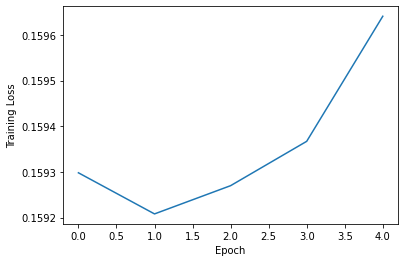

In [30]:
# plot training loss
loss = [train_results['losses'][epoch]['Batch={}_epoch={}'.format(n_batches, epoch+1)]['{}-classification'.format(
        rnn.decoders.readouts[0].label)]['raw-MSE'] for epoch in range(n_epochs)]
fig, ax = plt.subplots()
ax.plot(loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")

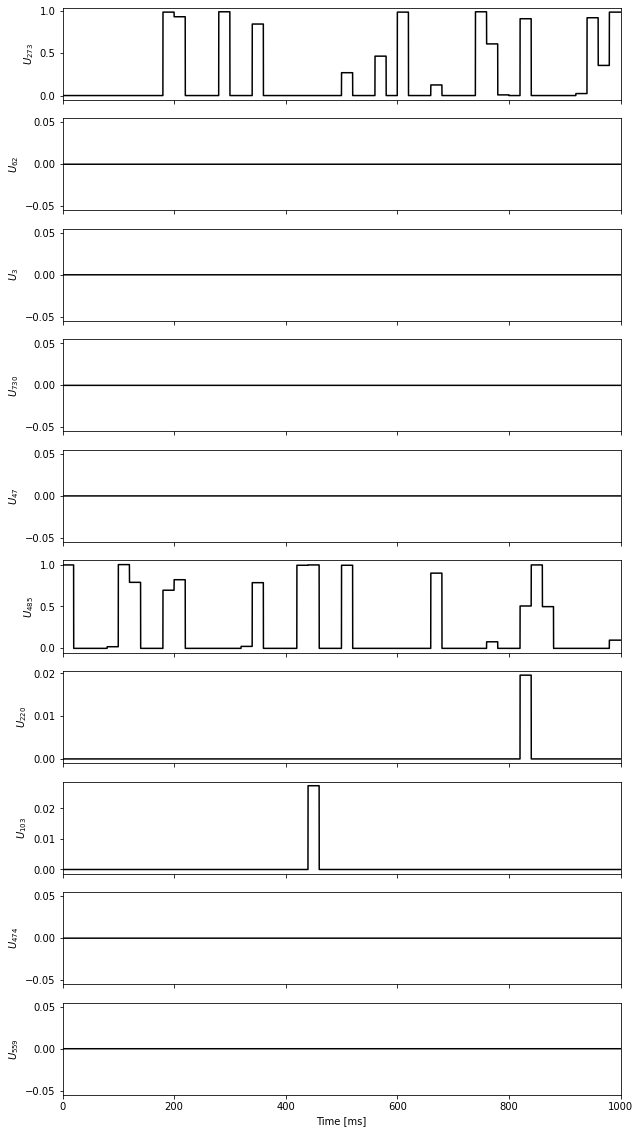

In [31]:
# Plot sample input signals
batch_time_axis = np.arange(0., signal_pars['duration'] * batch_size, resolution)
input_signal, _ = image_mnist.draw_stimulus_sequence(train_batch['inputs'][-1], continuous=True, unfold=True,
                                                     onset_time=0., verbose=False)
input_signal = input_signal.as_array()
input_dimensions = input_signal.shape[0]
if input_dimensions > 10:
    input_idx = np.random.permutation(input_dimensions)[:10]
    input_dimensions = 10
else:
    input_idx = np.arange(input_dimensions)

fig1, axes = plt.subplots(input_dimensions, 1, sharex=True, figsize=(10, 2*input_dimensions))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for idx, (neuron, ax) in enumerate(zip(input_idx, axes)):
    ax.plot(batch_time_axis[t_idx[0]:t_idx[1]], input_signal[neuron, t_idx[0]:t_idx[1]], 'k')
    # ax.plot(batch_time_axis[t_idx[0]:t_idx[1]], target[neuron, t_idx[0]:t_idx[1]], 'r')
    ax.set_ylabel(r"$U_{"+"{0}".format(neuron)+"}$")
    ax.set_xlim(analysis_interval)
    if idx == input_dimensions - 1:
        ax.set_xlabel("Time [ms]")
plt.show()

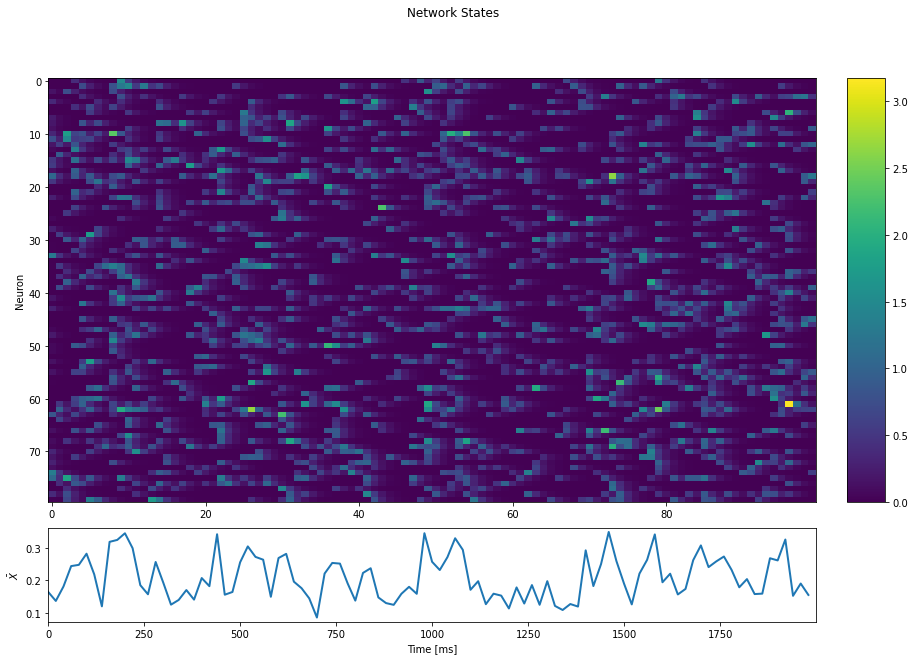

In [32]:
from fna.tools.visualization.plotting import plot_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

state_matrix = train_results['states'][-1][0].matrix
fig, (ax11, ax12) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [18, 4], 'hspace': 0.1}, sharex=False, figsize=(15, 10))
fig.suptitle("Network States")
_, ax11 = plot_matrix(state_matrix, ax=ax11, save=False, display=False, data_label=None)
ax11.set_ylabel('Neuron')
ax12.plot(batch_time_axis[::int(signal_pars['duration'] / resolution)], state_matrix.mean(0), lw=2)
divider2 = make_axes_locatable(ax12)
cax2 = divider2.append_axes("right", size="5%", pad="4%")
cax2.remove()
ax12.set_xlabel("Time [ms]")
ax12.set_xlim([batch_time_axis.min(), batch_time_axis.max()])
ax12.set_ylabel(r"$\bar{X}$")
plt.show()

[metrics.py:407 - INFO] Explained Variance (first 3 components): [0.06605924 0.05787277 0.05250873]
[metrics.py:1317 - INFO] Determining effective dimensionality...
[metrics.py:1330 - INFO] Effective dimensionality = 34.29
[metrics.py:1331 - INFO] Elapsed Time: 0.001 s


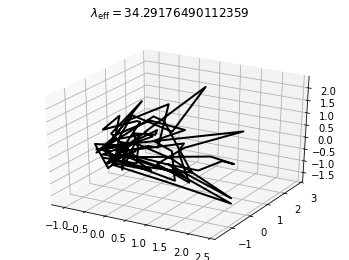

In [33]:
from fna.tools.analysis.metrics import analyse_state_matrix
from fna.tools.visualization.plotting import plot_trajectory

fig3 = plt.figure()
ax31 = fig3.add_subplot(111, projection='3d')
effective_dimensionality = analyse_state_matrix(state_matrix, stim_labels=None, epochs=None, label=None, plot=False,
                                                display=True, save=False)['dimensionality']
fig3.suptitle(r"$\lambda_{\mathrm{eff}}="+"{}".format(effective_dimensionality)+"$")
plot_trajectory(state_matrix[:, t_idx[0]:t_idx[1]], label="Sample Trajectory", ax=ax31, color='k', display=False, save=False)

### 10.4.2. Analog tasks

Here, we will use a continuous integration task as an example:

In [44]:
from fna.networks.rnn.helper import prepare_analog_batch
from fna.tasks.symbolic.embeddings import VectorEmbeddings

In [45]:
# task parameters
n_epochs = 10
n_batches = 5
batch_size = 100

sequencer = SymbolicSequencer(label='random sequence', alphabet=['A', 'B'], eos='#')
embedding = VectorEmbeddings(vocabulary=sequencer.tokens).one_hot()
embedding.stimulus_set.update({'#': np.zeros_like(embedding.stimulus_set['A']),
                               'B': -1*embedding.stimulus_set['B']})

# inputs
signal_pars = {
    'duration': 10., # [ms]
    'amplitude': 1., # [max. rate]
    'kernel': ('box', {}),# (kernel, {kernel_pars})
    'dt': resolution # [ms]
}
sig = embedding.unfold(to_signal=True, **signal_pars)
sequencer.generate_stringset(set_length=batch_size, length_range=(2, 2), verbose=False)
batch_seq = sequencer.generate_sequence()
sequencer.string_set = []
batch_time = (signal_pars['duration'] * len(batch_seq)) / resolution

[sequences.py:91 - INFO] Generating symbolic sequencer
[embeddings.py:366 - INFO] Populating Stimulus Set: 


In [48]:
example_defaults.reset_kernel(resolution=0.1)
rnn, rnn_recurrent_connections = example_defaults.default_network(N=100, record_spikes=True)

encoder = NESTEncoder('inhomogeneous_poisson_generator', label='poisson-input', dim=2)
# input synapses
input_synapses = {
    'connect_populations': [('E', encoder.name), ('I', encoder.name), ],
    'weight_matrix': [None, None],
    'conn_specs': [{'rule': 'all_to_all'}, {'rule': 'all_to_all'}],
    'syn_specs': [{'model': 'static_synapse', 'delay': 0.1, 'weight': 1.}, {'model': 'static_synapse', 'delay': 0.1, 'weight': 1.}]}
in_to_rnn_connections = InputMapper(source=encoder, target=rnn, parameters=input_synapses)

[__init__.py:49 - INFO] Initializing Brunel BRN architecture (NEST-simulated)
[__init__.py:125 - INFO] Creating populations:
[__init__.py:117 - INFO] - Population E, with ids [1-80]
[__init__.py:117 - INFO] - Population I, with ids [81-100]
[__init__.py:428 - INFO] Connecting Devices: 
[__init__.py:128 - INFO]   - Attaching spike_detector with gid [(101,)] to population E
[__init__.py:448 - INFO] - Connecting spike_detector to E, with label E_spike_detector and id (101,)
[__init__.py:128 - INFO]   - Attaching spike_detector with gid [(102,)] to population I
[__init__.py:448 - INFO] - Connecting spike_detector to I, with label I_spike_detector and id (102,)
[__init__.py:145 - INFO] Initializing state variables:
[__init__.py:94 - INFO] - Randomizing V_m state in Population E
[__init__.py:94 - INFO] - Randomizing V_m state in Population I
[__init__.py:1074 - INFO] ========================================================
[__init__.py:1075 - INFO]  Brunel BRN architecture (NEST-simulated):


In [49]:
# decoder
extractor_parameters = {'E_Vm_@offset': {'population': 'E', 'variable': 'V_m', 'sampling_times': ['stim_offset']}}
decoding_parameters = {'SGD-Regression': {'algorithm': "sgd-reg", 'extractor': 'E_Vm_@offset', 'save': True},}

# create and connect extractors and decoders
rnn.connect_state_extractors(extractor_parameters, encoder=encoder, input_mapper=in_to_rnn_connections,
                             stim_duration=signal_pars['duration'], stim_isi=None, stim_onset=rnn.next_onset_time(),
                             to_memory=True)
rnn.create_decoder(decoding_parameters)
total_delay = in_to_rnn_connections.total_delay + rnn.state_extractor.max_extractor_delay

[extractors.py:498 - INFO] Connecting extractors (SpikingExtractor):
[extractors.py:504 - INFO] 	- State [E_Vm_@offset] from populations E [V_m]
[extractors.py:311 - INFO] 	  - Extractor (offset sampling)
[extractors.py:312 - INFO] 		- offset = 10.2 ms (stimulus onset + total delay + sim_res step)
[extractors.py:313 - INFO] 		- interval = 10.0 ms
[extractors.py:536 - INFO] 		- total delays = 0.2 ms (0.1 encoder + 0.1 extractor delay)
[extractors.py:538 - INFO] 		- NEST device id(s): [105]


In [50]:
# train
train_batch = prepare_analog_batch(rnn.simulator, n_batches=n_batches, batch_size=batch_size,
                                   batch_time=int(batch_time), sequencer=sequencer, continuous_embedding=sig,
                                   as_tensor=True)
train_results = rnn.train(train_batch, n_epochs, sig, encoder, rnn.next_onset_time(),
                          total_delay=total_delay, symbolic=False, continuous=continuous, verbose=True, save=False)

[__init__.py:83 - INFO] Initializing and connecting decoder...
[__init__.py:93 - INFO] Creating readouts:
[readouts.py:50 - INFO]   - SGD-Regression trained with sgd-reg on integrator, using state E_Vm_@offset
[__init__.py:706 - INFO] 
[__init__.py:707 - INFO] ################## Simulating batch Batch=1_epoch=1
[__init__.py:874 - INFO] Initializing training batch Batch=2_epoch=1
[__init__.py:750 - INFO] Simulating delays from batch Batch=1_epoch=1
[__init__.py:754 - INFO] Post-processing batch Batch=1_epoch=1
[extractors.py:813 - INFO] Extracting and storing recorded activity from state extractor E_Vm_@offset
[extractors.py:850 - INFO]   - Reading extractor 105 [V_m] at sampling offset
[extractors.py:591 - INFO]   - Flushing devices of state extractor E_Vm_@offset [105] from populations V_m
[extractors.py:897 - INFO] Compiling state matrices...
[extractors.py:918 - INFO] 
[extractors.py:919 - INFO] ==========================
[extractors.py:920 - INFO] SNN StateExtractor summary
[extrac

In [ ]:
# test
test_batch = prepare_analog_batch(simulator=rnn.simulator, n_batches=1, batch_size=batch_size,
                                         sequencer=sequencer, continuous_embedding=image_mnist,
                                         batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                         decoder_output_pars=None)
test_results = rnn.test(test_batch, sig, encoder, rnn.next_onset_time(), total_delay=total_delay,
                        symbolic=False, continuous=continuous, output_parsing=None)

## 10.5. Optimization

Plasticity (unsupervised learning), transfer learning

---